In [1]:
!pip install pygame

from __future__ import annotations
from collections import defaultdict, deque

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import random
import cv2

import gymnasium as gym
from gymnasium.utils.play import play

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 78.9 MB/s eta 0:00:00:00:0100:01


2024-07-30 09:18:24.555166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 09:18:24.555334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 09:18:24.702080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/gymnasium/utils/play.py:29: UserWarning: WARN: matplotlib is not installed, run `pip install gymnasium[other]`
  logger.warn("matplotlib is not installed, run `pip install gymnasium[other]`")


In [2]:
# Install SWIG and build-essential
!apt-get update
!apt-get install -y swig build-essential

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1557 kB]
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [1616 B]       
Hit:7 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [24.8 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3124 kB]
Hit:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease     
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [148

In [3]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=494460 sha256=542d25b533a2b510274b0b91215cd655d2c271cf24e58e0934ea0ee4a7ae5da7
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [4]:
def build_model(input_shape, action_space):
    model = models.Sequential()
    model.add(layers.Conv2D(16, (8, 8), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (4, 4), strides=(2, 2), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(action_space, activation='linear'))
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.001))
    return model

In [5]:
class DQNAgent:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99    # Discount factor
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        self.model = build_model(state_shape, action_space)
        self.target_model = build_model(state_shape, action_space)
        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        q_values = self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

In [6]:
from IPython import display

def render_env(env):
    img = env.render()
    plt.imshow(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)

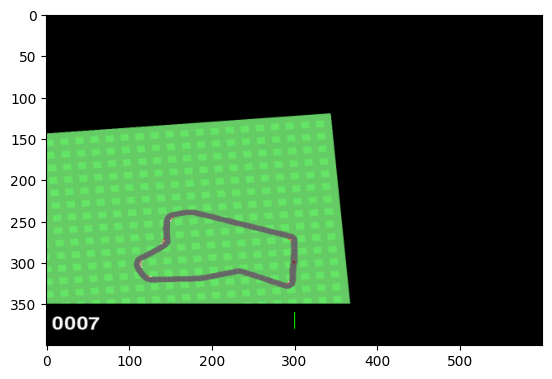

In [7]:
env = gym.make("CarRacing-v2", domain_randomize=False, render_mode="rgb_array")

# normal reset, this changes the colour scheme by default
env.reset()
render_env(env)

In [8]:
n_episodes = 1000

agent = DQNAgent((96, 96, 3), (5))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
env = gym.make("CarRacing-v2", domain_randomize=False, continuous=False, render_mode="rgb_array")

for e in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.remember(obs, action, reward, next_obs, terminated)
        
        done = terminated or truncated
        obs = next_obs
        total_reward += reward
        
        if done:
            agent.update_target_model()
            print(f"Episode: {e}/{n_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

  0%|          | 1/1000 [00:14<3:56:54, 14.23s/it]

Episode: 0/1000, Total Reward: -44.66403162055401, Epsilon: 1.00


  0%|          | 2/1000 [00:28<3:59:53, 14.42s/it]

Episode: 1/1000, Total Reward: -62.83783783783873, Epsilon: 1.00


  0%|          | 3/1000 [00:43<4:05:07, 14.75s/it]

Episode: 2/1000, Total Reward: -58.33333333333418, Epsilon: 1.00


  0%|          | 4/1000 [00:59<4:07:46, 14.93s/it]

Episode: 3/1000, Total Reward: -60.00000000000082, Epsilon: 1.00


  0%|          | 5/1000 [01:14<4:10:17, 15.09s/it]

Episode: 4/1000, Total Reward: -52.07667731629469, Epsilon: 1.00


  1%|          | 6/1000 [01:28<4:05:11, 14.80s/it]

Episode: 5/1000, Total Reward: -53.06859205776249, Epsilon: 1.00


  1%|          | 7/1000 [01:42<4:01:54, 14.62s/it]

Episode: 6/1000, Total Reward: -42.62295081967271, Epsilon: 1.00


  1%|          | 8/1000 [01:57<4:01:59, 14.64s/it]

Episode: 7/1000, Total Reward: -59.04436860068341, Epsilon: 1.00


  1%|          | 9/1000 [02:11<3:59:47, 14.52s/it]

Episode: 8/1000, Total Reward: -57.36434108527208, Epsilon: 1.00


  1%|          | 10/1000 [02:27<4:02:41, 14.71s/it]

Episode: 9/1000, Total Reward: -51.140065146580596, Epsilon: 1.00


  1%|          | 11/1000 [02:41<3:59:42, 14.54s/it]

Episode: 10/1000, Total Reward: -54.1984732824436, Epsilon: 1.00


  1%|          | 12/1000 [02:55<4:00:20, 14.60s/it]

Episode: 11/1000, Total Reward: -51.890034364261936, Epsilon: 1.00


  1%|▏         | 13/1000 [03:11<4:03:21, 14.79s/it]

Episode: 12/1000, Total Reward: -62.96296296296387, Epsilon: 1.00


  1%|▏         | 14/1000 [03:26<4:05:31, 14.94s/it]

Episode: 13/1000, Total Reward: -59.3750000000008, Epsilon: 1.00


  2%|▏         | 15/1000 [03:40<4:02:58, 14.80s/it]

Episode: 14/1000, Total Reward: -61.40350877193065, Epsilon: 1.00


  2%|▏         | 16/1000 [03:55<4:03:34, 14.85s/it]

Episode: 15/1000, Total Reward: -51.89003436426195, Epsilon: 1.00


  2%|▏         | 17/1000 [04:10<4:02:58, 14.83s/it]

Episode: 16/1000, Total Reward: -62.45733788395986, Epsilon: 1.00


  2%|▏         | 18/1000 [04:25<4:04:12, 14.92s/it]

Episode: 17/1000, Total Reward: -59.73154362416198, Epsilon: 1.00


  2%|▏         | 19/1000 [04:40<4:03:05, 14.87s/it]

Episode: 18/1000, Total Reward: -54.54545454545536, Epsilon: 1.00


  2%|▏         | 20/1000 [04:55<4:02:45, 14.86s/it]

Episode: 19/1000, Total Reward: -54.86111111111199, Epsilon: 1.00


  2%|▏         | 21/1000 [05:10<4:02:12, 14.84s/it]

Episode: 20/1000, Total Reward: -57.85440613026892, Epsilon: 1.00


  2%|▏         | 22/1000 [05:25<4:01:54, 14.84s/it]

Episode: 21/1000, Total Reward: -48.71794871794945, Epsilon: 1.00


  2%|▏         | 23/1000 [05:40<4:05:11, 15.06s/it]

Episode: 22/1000, Total Reward: -60.48632218845073, Epsilon: 1.00


  2%|▏         | 24/1000 [05:55<4:04:04, 15.00s/it]

Episode: 23/1000, Total Reward: -48.275862068966326, Epsilon: 1.00


  2%|▎         | 25/1000 [06:09<4:01:21, 14.85s/it]

Episode: 24/1000, Total Reward: -52.89855072463841, Epsilon: 1.00


  3%|▎         | 26/1000 [06:25<4:03:11, 14.98s/it]

Episode: 25/1000, Total Reward: -59.6273291925474, Epsilon: 1.00


  3%|▎         | 27/1000 [06:40<4:02:34, 14.96s/it]

Episode: 26/1000, Total Reward: -54.225352112676816, Epsilon: 1.00


  3%|▎         | 28/1000 [06:55<4:02:18, 14.96s/it]

Episode: 27/1000, Total Reward: -47.183098591549914, Epsilon: 1.00


  3%|▎         | 29/1000 [07:10<4:05:09, 15.15s/it]

Episode: 28/1000, Total Reward: -60.00000000000083, Epsilon: 1.00


  3%|▎         | 30/1000 [07:26<4:09:32, 15.44s/it]

Episode: 29/1000, Total Reward: -66.10169491525497, Epsilon: 1.00


  3%|▎         | 31/1000 [07:41<4:05:21, 15.19s/it]

Episode: 30/1000, Total Reward: -50.57034220532393, Epsilon: 1.00


  3%|▎         | 32/1000 [07:56<4:05:45, 15.23s/it]

Episode: 31/1000, Total Reward: -61.661341853035964, Epsilon: 1.00


  3%|▎         | 33/1000 [08:11<4:03:06, 15.08s/it]

Episode: 32/1000, Total Reward: -56.0810810810819, Epsilon: 1.00


  3%|▎         | 34/1000 [08:25<3:57:17, 14.74s/it]

Episode: 33/1000, Total Reward: -48.00000000000077, Epsilon: 1.00


  4%|▎         | 35/1000 [08:40<3:59:46, 14.91s/it]

Episode: 34/1000, Total Reward: -54.9839228295828, Epsilon: 1.00


  4%|▎         | 36/1000 [08:55<4:00:18, 14.96s/it]

Episode: 35/1000, Total Reward: -50.38167938931377, Epsilon: 1.00


  4%|▎         | 37/1000 [09:11<4:01:46, 15.06s/it]

Episode: 36/1000, Total Reward: -58.19935691318411, Epsilon: 1.00


  4%|▍         | 38/1000 [09:26<4:01:36, 15.07s/it]

Episode: 37/1000, Total Reward: -57.894736842106006, Epsilon: 1.00


  4%|▍         | 39/1000 [09:41<4:00:53, 15.04s/it]

Episode: 38/1000, Total Reward: -62.457337883959916, Epsilon: 1.00


  4%|▍         | 40/1000 [09:56<4:00:33, 15.04s/it]

Episode: 39/1000, Total Reward: -56.22895622895704, Epsilon: 1.00


  4%|▍         | 41/1000 [10:11<3:59:08, 14.96s/it]

Episode: 40/1000, Total Reward: -55.882352941177324, Epsilon: 1.00


  4%|▍         | 42/1000 [10:25<3:57:54, 14.90s/it]

Episode: 41/1000, Total Reward: -56.81063122923666, Epsilon: 1.00


  4%|▍         | 43/1000 [10:40<3:58:34, 14.96s/it]

Episode: 42/1000, Total Reward: -58.620689655173294, Epsilon: 1.00


  4%|▍         | 44/1000 [10:55<3:57:44, 14.92s/it]

Episode: 43/1000, Total Reward: -47.73519163763146, Epsilon: 1.00


  4%|▍         | 45/1000 [11:10<3:58:48, 15.00s/it]

Episode: 44/1000, Total Reward: -56.834532374101585, Epsilon: 1.00


  5%|▍         | 46/1000 [11:25<3:56:57, 14.90s/it]

Episode: 45/1000, Total Reward: -48.339483394834666, Epsilon: 1.00


  5%|▍         | 47/1000 [11:40<3:54:32, 14.77s/it]

Episode: 46/1000, Total Reward: -49.41634241245206, Epsilon: 1.00


  5%|▍         | 48/1000 [11:54<3:52:03, 14.63s/it]

Episode: 47/1000, Total Reward: -51.61290322580724, Epsilon: 1.00


  5%|▍         | 49/1000 [12:09<3:53:31, 14.73s/it]

Episode: 48/1000, Total Reward: -58.18815331010536, Epsilon: 1.00


  5%|▌         | 50/1000 [12:24<3:56:02, 14.91s/it]

Episode: 49/1000, Total Reward: -54.248366013072676, Epsilon: 1.00


  5%|▌         | 51/1000 [12:39<3:54:59, 14.86s/it]

Episode: 50/1000, Total Reward: -48.6301369863022, Epsilon: 1.00


  5%|▌         | 52/1000 [12:54<3:54:43, 14.86s/it]

Episode: 51/1000, Total Reward: -59.32203389830592, Epsilon: 1.00


  5%|▌         | 53/1000 [13:08<3:49:58, 14.57s/it]

Episode: 52/1000, Total Reward: -51.21951219512265, Epsilon: 1.00


  5%|▌         | 54/1000 [13:23<3:54:53, 14.90s/it]

Episode: 53/1000, Total Reward: -57.70392749244799, Epsilon: 1.00


  6%|▌         | 55/1000 [13:38<3:53:43, 14.84s/it]

Episode: 54/1000, Total Reward: -55.93220338983141, Epsilon: 1.00


  6%|▌         | 56/1000 [13:53<3:55:38, 14.98s/it]

Episode: 55/1000, Total Reward: -51.45631067961239, Epsilon: 1.00


  6%|▌         | 57/1000 [14:08<3:55:40, 15.00s/it]

Episode: 56/1000, Total Reward: -50.49504950495123, Epsilon: 1.00


  6%|▌         | 58/1000 [14:23<3:55:04, 14.97s/it]

Episode: 57/1000, Total Reward: -59.04436860068345, Epsilon: 1.00


  6%|▌         | 59/1000 [14:38<3:53:06, 14.86s/it]

Episode: 58/1000, Total Reward: -56.04395604395689, Epsilon: 1.00


  6%|▌         | 60/1000 [14:53<3:52:32, 14.84s/it]

Episode: 59/1000, Total Reward: -48.339483394834616, Epsilon: 1.00


  6%|▌         | 61/1000 [15:08<3:54:55, 15.01s/it]

Episode: 60/1000, Total Reward: -60.91205211726472, Epsilon: 1.00


  6%|▌         | 62/1000 [15:23<3:54:11, 14.98s/it]

Episode: 61/1000, Total Reward: -58.477508650519894, Epsilon: 1.00


  6%|▋         | 63/1000 [15:37<3:51:49, 14.84s/it]

Episode: 62/1000, Total Reward: -56.52173913043561, Epsilon: 1.00


  6%|▋         | 64/1000 [15:53<3:54:56, 15.06s/it]

Episode: 63/1000, Total Reward: -56.79012345679089, Epsilon: 1.00


  6%|▋         | 65/1000 [16:08<3:53:29, 14.98s/it]

Episode: 64/1000, Total Reward: -55.479452054795345, Epsilon: 1.00


  7%|▋         | 66/1000 [16:23<3:54:16, 15.05s/it]

Episode: 65/1000, Total Reward: -54.248366013072605, Epsilon: 1.00


  7%|▋         | 67/1000 [16:37<3:50:56, 14.85s/it]

Episode: 66/1000, Total Reward: -49.64028776978486, Epsilon: 1.00


  7%|▋         | 68/1000 [16:52<3:50:16, 14.82s/it]

Episode: 67/1000, Total Reward: -52.20588235294199, Epsilon: 1.00


  7%|▋         | 69/1000 [17:07<3:48:24, 14.72s/it]

Episode: 68/1000, Total Reward: -57.29537366548128, Epsilon: 1.00


  7%|▋         | 70/1000 [17:22<3:52:14, 14.98s/it]

Episode: 69/1000, Total Reward: -52.380952380953154, Epsilon: 1.00


  7%|▋         | 71/1000 [17:37<3:52:50, 15.04s/it]

Episode: 70/1000, Total Reward: -56.386292834891755, Epsilon: 1.00


  7%|▋         | 72/1000 [17:52<3:51:24, 14.96s/it]

Episode: 71/1000, Total Reward: -53.57142857142937, Epsilon: 1.00


  7%|▋         | 73/1000 [18:07<3:50:35, 14.93s/it]

Episode: 72/1000, Total Reward: -52.05479452054882, Epsilon: 1.00


  7%|▋         | 74/1000 [18:22<3:50:19, 14.92s/it]

Episode: 73/1000, Total Reward: -58.04195804195888, Epsilon: 1.00


  8%|▊         | 75/1000 [18:37<3:49:53, 14.91s/it]

Episode: 74/1000, Total Reward: -60.52631578947451, Epsilon: 1.00


  8%|▊         | 76/1000 [18:52<3:49:49, 14.92s/it]

Episode: 75/1000, Total Reward: -55.172413793104255, Epsilon: 1.00


  8%|▊         | 77/1000 [19:07<3:50:26, 14.98s/it]

Episode: 76/1000, Total Reward: -50.57034220532398, Epsilon: 1.00


  8%|▊         | 78/1000 [19:21<3:47:51, 14.83s/it]

Episode: 77/1000, Total Reward: -47.36842105263226, Epsilon: 1.00


  8%|▊         | 79/1000 [19:36<3:48:37, 14.89s/it]

Episode: 78/1000, Total Reward: -60.132890365449406, Epsilon: 1.00


  8%|▊         | 80/1000 [19:52<3:51:26, 15.09s/it]

Episode: 79/1000, Total Reward: -61.78343949044679, Epsilon: 1.00


  8%|▊         | 81/1000 [20:08<3:54:28, 15.31s/it]

Episode: 80/1000, Total Reward: -58.73015873015954, Epsilon: 1.00


  8%|▊         | 82/1000 [20:23<3:51:48, 15.15s/it]

Episode: 81/1000, Total Reward: -55.01730103806309, Epsilon: 1.00


  8%|▊         | 83/1000 [20:37<3:49:57, 15.05s/it]

Episode: 82/1000, Total Reward: -52.218430034130456, Epsilon: 1.00


  8%|▊         | 84/1000 [20:52<3:47:40, 14.91s/it]

Episode: 83/1000, Total Reward: -54.37262357414525, Epsilon: 1.00


  8%|▊         | 85/1000 [21:07<3:46:20, 14.84s/it]

Episode: 84/1000, Total Reward: -54.198473282443516, Epsilon: 1.00


  9%|▊         | 86/1000 [21:21<3:44:44, 14.75s/it]

Episode: 85/1000, Total Reward: -49.275362318841395, Epsilon: 1.00


  9%|▊         | 87/1000 [21:37<3:50:02, 15.12s/it]

Episode: 86/1000, Total Reward: -60.606060606061426, Epsilon: 1.00


  9%|▉         | 88/1000 [21:52<3:46:36, 14.91s/it]

Episode: 87/1000, Total Reward: -45.94594594594648, Epsilon: 1.00


  9%|▉         | 89/1000 [22:06<3:45:51, 14.88s/it]

Episode: 88/1000, Total Reward: -51.8518518518526, Epsilon: 1.00


  9%|▉         | 90/1000 [22:21<3:43:54, 14.76s/it]

Episode: 89/1000, Total Reward: -48.905109489051846, Epsilon: 1.00


  9%|▉         | 91/1000 [22:36<3:45:31, 14.89s/it]

Episode: 90/1000, Total Reward: -50.495049504951176, Epsilon: 1.00


  9%|▉         | 92/1000 [22:51<3:46:38, 14.98s/it]

Episode: 91/1000, Total Reward: -62.45733788395992, Epsilon: 1.00


  9%|▉         | 93/1000 [23:06<3:45:35, 14.92s/it]

Episode: 92/1000, Total Reward: -58.95522388059786, Epsilon: 1.00


  9%|▉         | 94/1000 [23:21<3:44:00, 14.83s/it]

Episode: 93/1000, Total Reward: -48.4126984126991, Epsilon: 1.00


 10%|▉         | 95/1000 [23:36<3:44:41, 14.90s/it]

Episode: 94/1000, Total Reward: -57.792207792208586, Epsilon: 1.00


 10%|▉         | 96/1000 [23:50<3:43:45, 14.85s/it]

Episode: 95/1000, Total Reward: -52.38095238095313, Epsilon: 1.00


 10%|▉         | 97/1000 [24:05<3:43:35, 14.86s/it]

Episode: 96/1000, Total Reward: -55.47945205479531, Epsilon: 1.00


 10%|▉         | 98/1000 [24:20<3:43:11, 14.85s/it]

Episode: 97/1000, Total Reward: -54.22535211267684, Epsilon: 1.00


 10%|▉         | 99/1000 [24:35<3:43:26, 14.88s/it]

Episode: 98/1000, Total Reward: -53.0201342281887, Epsilon: 1.00


 10%|█         | 100/1000 [24:50<3:44:43, 14.98s/it]

Episode: 99/1000, Total Reward: -60.132890365449406, Epsilon: 1.00


 10%|█         | 101/1000 [25:05<3:43:06, 14.89s/it]

Episode: 100/1000, Total Reward: -59.409594095941806, Epsilon: 1.00


 10%|█         | 102/1000 [25:20<3:43:32, 14.94s/it]

Episode: 101/1000, Total Reward: -43.1818181818188, Epsilon: 1.00


 10%|█         | 103/1000 [25:35<3:41:17, 14.80s/it]

Episode: 102/1000, Total Reward: -47.95539033457321, Epsilon: 1.00


 10%|█         | 104/1000 [25:50<3:42:50, 14.92s/it]

Episode: 103/1000, Total Reward: -57.37704918032874, Epsilon: 1.00


 10%|█         | 105/1000 [26:04<3:41:26, 14.85s/it]

Episode: 104/1000, Total Reward: -55.32646048110049, Epsilon: 1.00


 11%|█         | 106/1000 [26:19<3:41:52, 14.89s/it]

Episode: 105/1000, Total Reward: -56.36363636363717, Epsilon: 1.00


 11%|█         | 107/1000 [26:34<3:39:02, 14.72s/it]

Episode: 106/1000, Total Reward: -46.56488549618394, Epsilon: 1.00


 11%|█         | 108/1000 [26:49<3:40:10, 14.81s/it]

Episode: 107/1000, Total Reward: -57.7922077922086, Epsilon: 1.00


 11%|█         | 109/1000 [27:04<3:39:54, 14.81s/it]

Episode: 108/1000, Total Reward: -56.37583892617533, Epsilon: 1.00


 11%|█         | 110/1000 [27:19<3:40:45, 14.88s/it]

Episode: 109/1000, Total Reward: -54.545454545455364, Epsilon: 1.00


 11%|█         | 111/1000 [27:34<3:41:23, 14.94s/it]

Episode: 110/1000, Total Reward: -64.51612903225899, Epsilon: 1.00


 11%|█         | 112/1000 [27:49<3:41:46, 14.99s/it]